# An EOF analysis of AO & NAO

In [ ]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts

In [109]:
import statsmodels.api as sm

In [2]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
#import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [213]:
def EOF(H, nmode=10, ndim=3, reverse=1):
    '''
    Converted from MATLAB to Python 2.7 code @ 2015/06/15 - YKS
     + ndim: [LAT, LON, TIME] data (=3) or [MAP, TIME] data (=2)
     + reverse: normalized spatial pattern (=0), normalized PC (=1)
    % ======================================================================= %
    % Input
    %   H: Variable required for EOF comutation, H(LAT, LON, Time) 
    %       or H(Space, Time) is accepted.
    %   nmode: Number of modes output
    % Output
    %   EOFs: EOF Spatial Pattern
    %   PC: Timeseries cooresponding to each EOFs
    %   expvar: Explained variance
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/3/18
    % ======================================================================= %
    '''
    ##import scipy.linalg.eig as eig
    # Get the size of array
    if ndim == 3:
        LAT, LON, T = H.shape
    elif ndim == 2:
        LON, T = H.shape
        LAT = 1
    # Covarience
    H = np.reshape(H, [LAT*LON, T]).T
    R=np.dot(H, H.T); N = np.size(R, 0)
    # Allocation
    PC     = np.zeros([nmode, T]);
    expvar = np.zeros([nmode]);
    eof    = np.zeros([N, LAT*LON]);
    EOFs   = np.zeros([LAT, LON, nmode]);
    # Eigvector analysis
    L, E = np.linalg.eig(R)
    # Get modes
    E    = np.dot(H.T, E)
    sq   = (np.sqrt(np.diag(L))+1e-16).T
    sq   = sq[0, :]
    E    = E/sq
    Z    = np.dot(E.T, H.T)
    for i in range(nmode):
        eof[i, :] = np.squeeze(E[:, i]).T
        PC[i, :]  = np.squeeze(Z[i, :])
    # Get expvar
    L = np.abs(L)
    dsum = np.sum(np.abs(L))
    # Output
    for i in range(nmode):
        expvar[i] = L[i]/dsum
        EOFs[:, :, i] = np.reshape(eof[i, :], [LAT, LON])
    if reverse==1:
        EOFs, PC = reverse_std(EOFs, PC, nmode)
    return EOFs, PC, expvar

def reverse_std(EOFs, PC, nmode):
    for i in range(nmode):
        STD = np.nanstd(PC[i, :])
        PC[i, :] = PC[i, :]/STD
        EOFs[:, :, i] = EOFs[:, :, i]*STD
    return EOFs, PC     

In [166]:
def seasonal_decomp(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 1D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    for mon in range(12):
        temp_data = data[mon:len(data):12]
        if method == 0:
            data[mon:len(data):12] = data[mon:len(data):12]-np.nanmean(temp_data)
        elif method == 1:
            data[mon:len(data):12] = (data[mon:len(data):12]-np.nanmean(temp_data))/np.nanstd(temp_data)
    return data 
def seasonal_decomp3d(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 3D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    for i in range(np.size(data, 0)):
        for j in range(np.size(data, 1)):
            data[i, j, :] = seasonal_decomp(data[i, j, :], method=0)
    return data

# Read data

In [218]:
nc_name = glob.glob('_data/Reanalysis/NCEP-NCAR/*.nc')

In [219]:
SLP = nc.Dataset(nc_name[1])

In [220]:
SLP.variables.keys()
y = SLP.variables['lat'][:]
x = SLP.variables['lon'][:]
lon, lat = np.meshgrid(x, y)
slp = SLP.variables['slp'][:]

In [221]:
slp = np.transpose(slp, [1, 2, 0])
slp_np = slp[y>0, :, :]
lon_np = lon[y>0, :]
lat_np = lat[y>0, :]
slp_np = seasonal_decomp3d(slp_np, method=0)

# EOF

In [222]:
EOFs, PC, expvar = EOF(slp_np, nmode=10, ndim=3, reverse=1)

# Plot

**First mode**

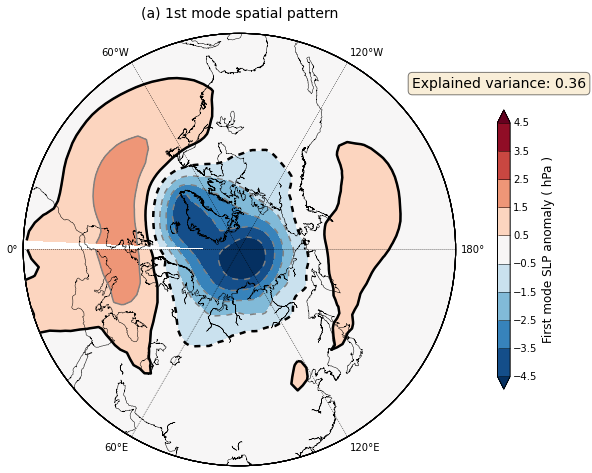

In [263]:
clevs = np.arange(-4.5, 5.5, 1)
#
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=90, round=True, area_thresh=5e4, ax=ax)
parallels=np.arange(-90, 90, 15)
meridians=np.arange(0, 360, 60)
proj.drawparallels(parallels, labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj.drawmeridians(meridians, labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(lon_np, lat_np)
CS = proj.contourf(x, y, EOFs[:, :, 0], clevs, cmap=plt.cm.RdBu_r, extend='both')
proj.contour(x, y, EOFs[:, :, 0], clevs, colors='gray', linewidths=1.5)
proj.contour(x, y, EOFs[:, :, 0], [-0.5, 0.5], colors='k', linewidths=2.5)
CBar = plt.colorbar(CS, shrink=0.5, pad = 0.075)
CBar.set_label('First mode SLP anomaly ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='y', length=12)
ax.set_title('(a) 1st mode spatial pattern', fontsize=14, y=1.025)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.90, 0.90, "Explained variance: %.2f"%expvar[0], transform=ax.transAxes, \
        fontsize=14, verticalalignment='top', bbox=props)

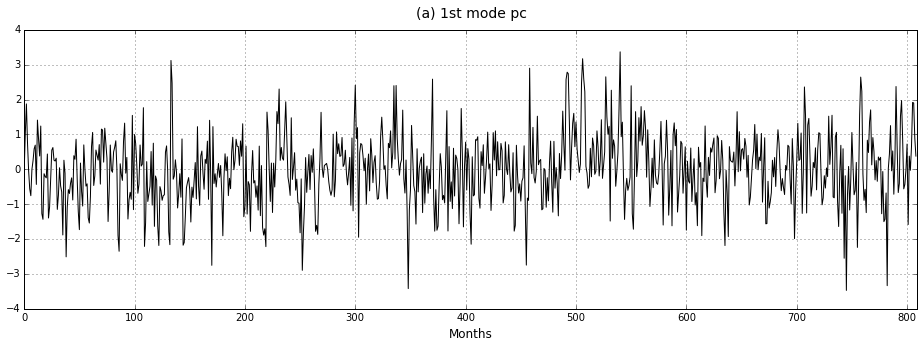

In [273]:
fig=plt.figure(figsize=(16, 5)); ax=plt.gca()
ax.plot(PC[0, :], color='k', lw=1)
ax.grid(); ax.set_xlim(0, 809)
ax.set_title('(a) 1st mode pc', fontsize=14, y=1.025)
ax.set_xlabel('Months', fontsize=12)